Download the data

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2023-03-15 17:47:30--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 2600:9000:2348:2c00:d:607e:4540:93a1, 2600:9000:2348:b600:d:607e:4540:93a1, 2600:9000:2348:d400:d:607e:4540:93a1, ...
Connecting to download.pytorch.org (download.pytorch.org)|2600:9000:2348:2c00:d:607e:4540:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.10’

data.zip.10         100%[===================>]   2.75M  10.4MB/s    in 0.3s    

2023-03-15 17:47:30 (10.4 MB/s) - ‘data.zip.10’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
2-cs480_winter23_asst4_char_rnn_classification (1).ipynb
Untitled.ipynb
Untitled1.ipynb
char_rnn_LSTM_classification_model.pt
char_rnn_classification_model.pt
cs480_winter23_asst4_char_rnn_classification.ipynb
cs480_winter23_asst4_char_rnn_generation.ipynb
cs480_winter23_asst4_seq2seq

In [37]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [38]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [39]:
print(n_letters)
print(category_lines['Italian'][:5])

57
['Caivano', 'Nieri', 'Di pasqua', 'Acerbi', 'Caiazzo']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [40]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [41]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)      

In [42]:
#Part 1 - LSTM model
#>>> rnn = nn.LSTM(10, 20, 2)
#>>> input = torch.randn(5, 3, 10)
#>>> h0 = torch.randn(2, 3, 20)
#>>> c0 = torch.randn(2, 3, 20)
#>>> output, (hn, cn) = rnn(input, (h0, c0))

class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.i2h = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden,cell):
        combined = torch.cat((input, hidden), 1)
        h_0 = hidden
        c_0 = cell
        out , (h_n,c_n) = self.lstm(input,(h_0,c_0))
        output = self.i2h(combined)
        output = self.softmax(output)
        return output, h_n, c_n



    def initHidden(self):
        return torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn_LSTM = RNN_LSTM(n_letters, n_hidden, n_categories)   

In [43]:
#Part 1 - GRU model
#>>> rnn = nn.LSTM(10, 20, 2)
#>>> input = torch.randn(5, 3, 10)
#>>> h0 = torch.randn(2, 3, 20)
#>>> c0 = torch.randn(2, 3, 20)
#>>> output, (hn, cn) = rnn(input, (h0, c0))

class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_GRU, self).__init__()

        self.hidden_size = hidden_size

        self.gru = nn.GRU(input_size, hidden_size)
        self.i2h = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        h_0 = hidden
        
        out , h_n = self.gru(input,h_0)
        output = self.i2h(combined)
        output = self.softmax(output)
        return output, h_n


    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn_GRU = RNN_GRU(n_letters, n_hidden, n_categories)   

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [44]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [45]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9696, -2.8475, -2.9487, -2.8539, -2.8088, -2.8320, -2.8697, -2.8039,
         -2.9444, -2.8434, -2.8900, -2.8672, -2.9381, -2.8947, -2.9261, -2.9691,
         -2.9581, -2.8868]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [46]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 7)


We will also want a quick way to get a training example (a name and its
language):




In [47]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Brun
category = Japanese / line = Yamagata
category = English / line = Hetherington
category = Arabic / line = Shamoon
category = Spanish / line = De la cruz
category = Portuguese / line = Ferro
category = Japanese / line = Ogyu
category = Dutch / line = Ter Avest
category = Italian / line = Scarsi
category = German / line = Von essen


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [48]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [49]:
optimizer = torch.optim.Adam(rnn.parameters())

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    # reset gradient
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

    return output, loss.item()

In [50]:
#Part 1 - LSTM
optimizer_LSTM = torch.optim.Adam(rnn_LSTM.parameters())

def train_LSTM(category_tensor, line_tensor):
    hidden,cell = rnn_LSTM.initHidden()
   

    # reset gradient
    rnn_LSTM.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden,cell = rnn_LSTM(line_tensor[i], hidden,cell)
    loss_LSTM = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss_LSTM.backward()

    # update parameters
    optimizer_LSTM.step()

    return output, loss_LSTM.item()

In [51]:
#Part 1 - GRU
optimizer_GRU = torch.optim.Adam(rnn_GRU.parameters())

def train_GRU(category_tensor, line_tensor):
    hidden= rnn_GRU.initHidden()
   

    # reset gradient
    rnn_GRU.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_GRU(line_tensor[i], hidden)
    loss_GRU= criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss_GRU.backward()

    # update parameters
    optimizer_GRU.step()

    return output, loss_GRU.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [52]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss = 0
all_train_losses = []
all_validation_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

def eval_dataset(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    train_loss += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset(validation_data)

        # save model with best validation loss
        if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
            torch.save(rnn, 'char_rnn_classification_model.pt')
        all_validation_losses.append(average_validation_loss)



Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 4s) 	1.8617 		Persein / French ✗ (Czech)
10000 	12% 	(0m 9s) 	1.5659 		Magalhaes / French ✗ (Portuguese)
15000 	18% 	(0m 14s) 	1.5613 		Slusser / German ✓
20000 	25% 	(0m 19s) 	1.3613 		Sadowski / Polish ✓
25000 	31% 	(0m 24s) 	1.2931 		Mann / Korean ✗ (German)
30000 	37% 	(0m 29s) 	1.2232 		Peary / Irish ✗ (Czech)
35000 	43% 	(0m 34s) 	1.1729 		Mai / Vietnamese ✓
40000 	50% 	(0m 39s) 	1.2264 		Horigoshi / Japanese ✓
45000 	56% 	(0m 44s) 	1.1522 		Bazhinov / Russian ✓
50000 	62% 	(0m 49s) 	1.1457 		Nakasawa / Japanese ✓
55000 	68% 	(0m 54s) 	1.2088 		Duarte / Spanish ✗ (Portuguese)
60000 	75% 	(0m 59s) 	1.1047 		Traver / French ✓
65000 	81% 	(1m 5s) 	1.1972 		Escarcega / Italian ✗ (Spanish)
70000 	87% 	(1m 10s) 	1.1852 		Kawachi / Japanese ✓
75000 	93% 	(1m 15s) 	1.1161 		Provenzano / Italian ✓
80000 	100% 	(1m 20s) 	1.1346 		Glaisyer / French ✓


In [53]:
#Part 1 lstm

import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_LSTM = 0
all_train_losses_LSTM = []
all_validation_losses_LSTM = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_LSTM(line_tensor):
    hidden, cell = rnn_LSTM.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden,cell = rnn_LSTM(line_tensor[i], hidden,cell)
    return output

def eval_dataset_LSTM(dataset):
    loss_LSTM = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_LSTM(line_tensor)
            loss_LSTM += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss_LSTM.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss_LSTM = train_LSTM(category_tensor, line_tensor)
    train_loss_LSTM += loss_LSTM

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_LSTM / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_LSTM.append(train_loss_LSTM / plot_every)
        train_loss_LSTM = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_LSTM, _ = eval_dataset_LSTM(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_LSTM) == 0 or average_validation_loss_LSTM < min(all_validation_losses_LSTM):
            torch.save(rnn_LSTM, 'char_rnn_LSTM_classification_model.pt')
        all_validation_losses_LSTM.append(average_validation_loss_LSTM)




Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 13s) 	1.8477 		Yoo / Korean ✓
10000 	12% 	(0m 29s) 	1.3252 		Widerlechner / Czech ✓
15000 	18% 	(0m 44s) 	1.1559 		Navratil / Greek ✗ (Czech)
20000 	25% 	(1m 0s) 	0.9580 		Nassar / Arabic ✓
25000 	31% 	(1m 15s) 	0.7549 		Diep / Vietnamese ✓
30000 	37% 	(1m 31s) 	0.6788 		Kanak / Czech ✓
35000 	43% 	(1m 46s) 	0.5679 		Chellos / Greek ✓
40000 	50% 	(2m 2s) 	0.5362 		Gorka / Polish ✓
45000 	56% 	(2m 18s) 	0.4661 		Yuasa / Japanese ✓
50000 	62% 	(2m 33s) 	0.4738 		Tomes / Czech ✓
55000 	68% 	(2m 49s) 	0.3856 		Naser / Arabic ✓
60000 	75% 	(3m 4s) 	0.3696 		Christakos / Greek ✓
65000 	81% 	(3m 20s) 	0.3252 		Mcnab / Irish ✓
70000 	87% 	(3m 35s) 	0.3427 		Simoes / Portuguese ✓
75000 	93% 	(3m 51s) 	0.2956 		Sitko / Polish ✓
80000 	100% 	(4m 7s) 	0.3165 		Koumanidis / Greek ✓


In [54]:
#Part 1 gru

import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_GRU = 0
all_train_losses_GRU = []
all_validation_losses_GRU = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_GRU(line_tensor):
    hidden = rnn_GRU.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_GRU(line_tensor[i], hidden)
    return output

def eval_dataset_GRU(dataset):
    loss_GRU = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_GRU(line_tensor)
            loss_GRU += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss_GRU.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss_GRU = train_GRU(category_tensor, line_tensor)
    train_loss_GRU += loss_GRU

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_GRU / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_GRU.append(train_loss_GRU / plot_every)
        train_loss_GRU = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_GRU, _ = eval_dataset_GRU(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_GRU) == 0 or average_validation_loss_GRU < min(all_validation_losses_GRU):
            torch.save(rnn_GRU, 'char_rnn_GRU_classification_model.pt')
        all_validation_losses_GRU.append(average_validation_loss_GRU)




Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 12s) 	1.6332 		Michurin / Russian ✓
10000 	12% 	(0m 26s) 	1.3370 		Castro / Portuguese ✓
15000 	18% 	(0m 40s) 	1.0247 		Wong / Korean ✗ (Chinese)
20000 	25% 	(0m 54s) 	0.8275 		Villeneuve / French ✓
25000 	31% 	(1m 8s) 	0.6820 		Cha / Korean ✓
30000 	37% 	(1m 53s) 	0.5824 		Kang / Chinese ✗ (Korean)
35000 	43% 	(2m 7s) 	0.6032 		O'Ryan / Irish ✓
40000 	50% 	(2m 21s) 	0.4562 		Santos / Portuguese ✓
45000 	56% 	(2m 34s) 	0.4534 		Cruz / Portuguese ✓
50000 	62% 	(2m 48s) 	0.3736 		Aldana / Spanish ✓
55000 	68% 	(3m 2s) 	0.3450 		Ekelchik / Russian ✓
60000 	75% 	(3m 17s) 	0.3551 		Mclain / Irish ✓
65000 	81% 	(3m 31s) 	0.3499 		Kamachi / Japanese ✓
70000 	87% 	(3m 45s) 	0.3052 		Sowka / Polish ✓
75000 	93% 	(3m 59s) 	0.2634 		Milne / Scottish ✓
80000 	100% 	(17m 12s) 	0.2386 		Marquerink / Dutch ✓


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




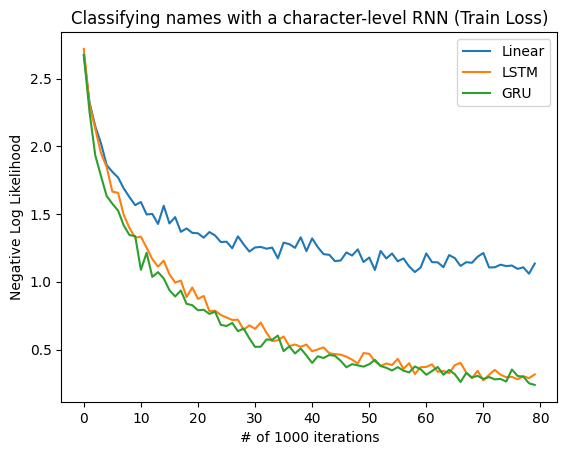

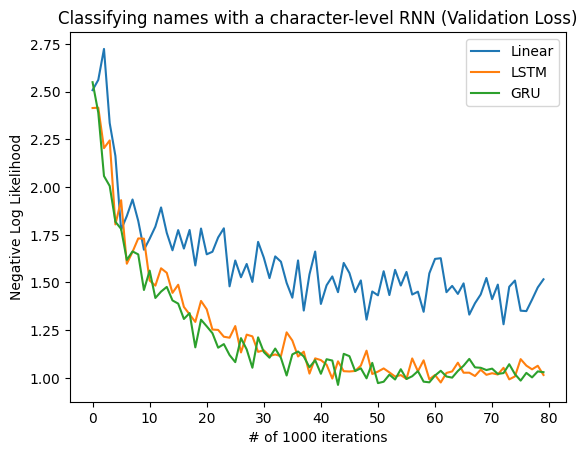

In [55]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses,label = 'Curve 1')
plt.plot(all_train_losses_LSTM,label ='Curve 2')
plt.plot(all_train_losses_GRU,label ='Curve 3')
plt.title('Classifying names with a character-level RNN (Train Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear','LSTM','GRU'], loc='upper right')


plt.figure()
plt.plot(all_validation_losses,label ='Curve 1')
plt.plot(all_validation_losses_LSTM,label ='Curve 2')
plt.plot(all_validation_losses_GRU,label ='Curve 3')
plt.title('Classifying names with a character-level RNN (Validation Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear','LSTM','GRU'], loc='upper right')


Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




Average test loss: 1.2497246197881957


/var/folders/v2/8xwj4fhn1c1cq81kmlwzl6700000gn/T/ipykernel_7345/1077404514.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/v2/8xwj4fhn1c1cq81kmlwzl6700000gn/T/ipykernel_7345/1077404514.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


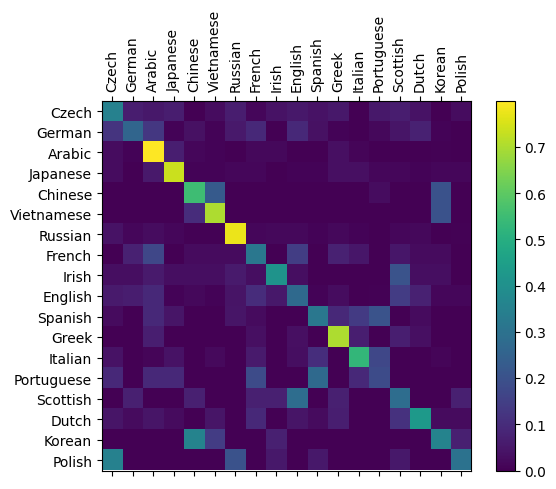

In [56]:
# evaluate on test set and display confusion matrix for RNN
rnn = torch.load('char_rnn_classification_model.pt')
average_test_loss, confusion = eval_dataset(test_data)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Average test loss LSTM: 0.9686055982641203


/var/folders/v2/8xwj4fhn1c1cq81kmlwzl6700000gn/T/ipykernel_7345/1646546954.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/v2/8xwj4fhn1c1cq81kmlwzl6700000gn/T/ipykernel_7345/1646546954.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


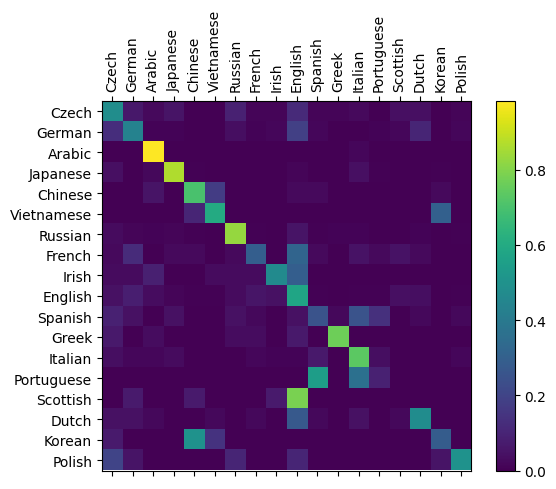

In [57]:
# evaluate on test set and display confusion matrix for lstm
rnn = torch.load('char_rnn_LSTM_classification_model.pt')
average_test_loss_LSTM, confusion_LSTM = eval_dataset_LSTM(test_data)
print('Average test loss LSTM: ' + str(average_test_loss_LSTM))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_LSTM.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Average test loss _GRU: 0.9696763676430773


/var/folders/v2/8xwj4fhn1c1cq81kmlwzl6700000gn/T/ipykernel_7345/539798535.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/v2/8xwj4fhn1c1cq81kmlwzl6700000gn/T/ipykernel_7345/539798535.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


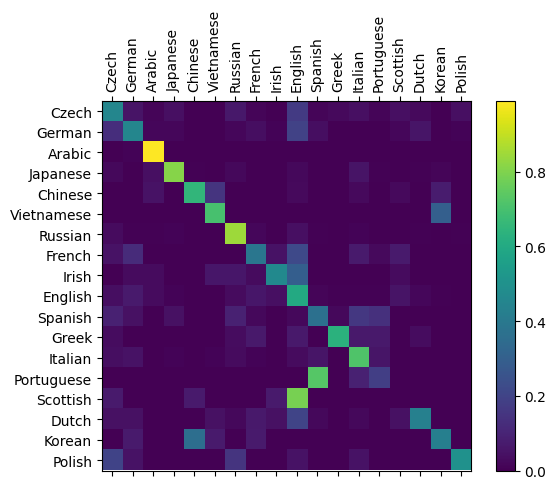

In [58]:
# evaluate on test set and display confusion matrix for  gru
rnn = torch.load('char_rnn_GRU_classification_model.pt')
average_test_loss_GRU, confusion_GRU = eval_dataset_GRU(test_data)
print('Average test loss _GRU: ' + str(average_test_loss_GRU))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_GRU.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [31]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')



> Dovesky
(-0.00) Russian
(-6.29) English
(-7.95) Czech

> Jackson
(-0.42) English
(-1.27) Scottish
(-2.81) Russian

> Satoshi
(-0.00) Japanese
(-9.03) Czech
(-9.33) Russian


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




## Explanation

#### RNN:
Recurrent Neural Network can handle variable data length(e.g. sequences, time series, spatial data). There are challenges invovles with RNN such as gradient vanishing and explosion, long range memory, and prediction shift. Also the size of the net depends on the size of the sequence. 

#### LSTM:
It is a special gated structure to control memorization and forgetting in RNNs. Although it facilitates long term memory(by using memory cells than can store information for longer), it mitigates gradient vanishing. Furthutmore, in each LSTM cell, there are several layers, and the deeper the network, (generally) it performs better.

#### GRU:
Gru has a simpler structure than lstm, with two gates instead of three. There is no cell state as opposed to lstm, and fewer weights are to be trained which is better. 

By the explanation given above, LSTM and GRU are expected to perform better than RNNs because they can remeber information for longer. However they need longer time to train, lstm and gru are desirable because they can handle the problem of gradient vanishig(explosion).
This is visible from the training and valiation loss graphs and test loss:

Average test loss: 1.2497246197881957



Additionally, GRU is expected to perform better, due to its simpler structure. As seen in the graphs, it performs slightly better than lstm. To speak more accurately, depending on the task, LSTM or GRU could perform better.

Average test loss LSTM: 0.9686055982641203
Average test loss _GRU: 0.9696763676430773



